In [374]:
#导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
plt.style.use('seaborn')
np.random.seed(100)

In [375]:
#设置神经网络参数
batch_size=64
epoch=10
train_ratio=.9
scale=1.0
#读取数据
df=pd.read_csv('data.csv') 
df=df.iloc[:,2:]
df.tail()

,open,low,close,high
26272,7.1042,7.1042,7.1048,7.1055
26273,7.1047,7.1038,7.1038,7.1047
26274,7.1039,7.1039,7.1046,7.1047
26275,7.1048,7.1043,7.1045,7.1049
26276,7.1049,7.1049,7.1057,7.1057


In [376]:
#划分训练集测试集
df = np.array(df)/scale
cut = round(train_ratio* df.shape[0])
x_train = df[:cut,:-1]
y_train = df[:cut,-1]
x_test = df[cut:,:-1]
y_test = df[cut:,-1]
input_size=len(x_test[1,:])
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(23649, 3) (23649,) (2628, 3) (2628,)


In [377]:
#建立模型 训练
inputs=Input(shape=(input_size))
attention=Dense(input_size, activation='sigmoid', name='attention_vec')(inputs)#求解Attention权重
attention=Activation('softmax',name='attention_weight')(attention)
#attention=RepeatVector(input_size)(attention)#重复几次输入
#attention=Flatten()(attention)#降低为一维
#attention=Permute([2,1])(attention)#置换维度
model=Multiply()([inputs, attention])#attention与LSTM对应数值相乘
model=Dense(input_size)(model)#全连接层
outputs = Dense(1)(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()#展示模型结构

Model: "functional_120"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 3)            12          input_47[0][0]                   
__________________________________________________________________________________________________
attention_weight (Activation)   (None, 3)            0           attention_vec[0][0]              
__________________________________________________________________________________________________
multiply_36 (Multiply)          (None, 3)            0           input_47[0][0]                   
                                                                 attention_weight[0][

In [378]:
history=model.fit(x_train, y_train, epochs = epoch, batch_size = batch_size,
                  shuffle=False,validation_split=.1) #训练模型epoch次

Epoch 1/10
333/333 [==============================] - 0s 851us/step - loss: 16.9977 - accuracy: 0.0000e+00 - val_loss: 0.4387 - val_accuracy: 0.0000e+00
Epoch 2/10
333/333 [==============================] - 0s 620us/step - loss: 0.0460 - accuracy: 0.0000e+00 - val_loss: 1.6613e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
333/333 [==============================] - 0s 624us/step - loss: 6.8778e-05 - accuracy: 0.0000e+00 - val_loss: 1.3613e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
333/333 [==============================] - 0s 623us/step - loss: 6.3861e-05 - accuracy: 0.0000e+00 - val_loss: 1.3354e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
333/333 [==============================] - 0s 625us/step - loss: 5.8846e-05 - accuracy: 0.0000e+00 - val_loss: 1.2785e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
333/333 [==============================] - 0s 630us/step - loss: 5.4392e-05 - accuracy: 0.0000e+00 - val_loss: 1.2288e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
333/333 [==============================]

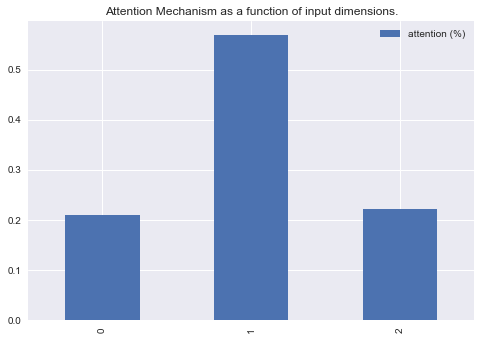

In [379]:
#获得网络权重
#weights = np.array(model.get_weights())
#print(weights)
#输出attention层权重
attention_layer_model = Model(inputs=model.input,outputs=model.get_layer('attention_weight').output)
attention_weight = attention_layer_model.predict(x_train)
attention_weight_final=np.mean(np.array(attention_weight), axis=0)
pd.DataFrame(attention_weight_final, columns=['attention (%)']).plot(kind='bar',
                                                                         title='Attention Mechanism as '
                                                                               'a function of input'
                                                                               ' dimensions.')
plt.show()

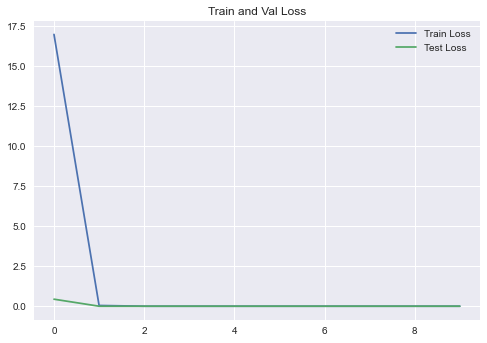

In [380]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

Text(0.5, 1.0, 'Train Data')

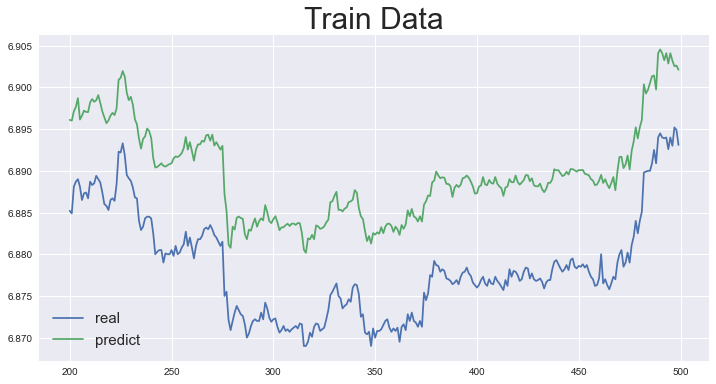

In [381]:
#在训练集上的拟合结果
y_train_predict=model.predict(x_train)*scale
y_train_predict=y_train_predict[:,0]
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题

Text(0.5, 1.0, 'Test Data')

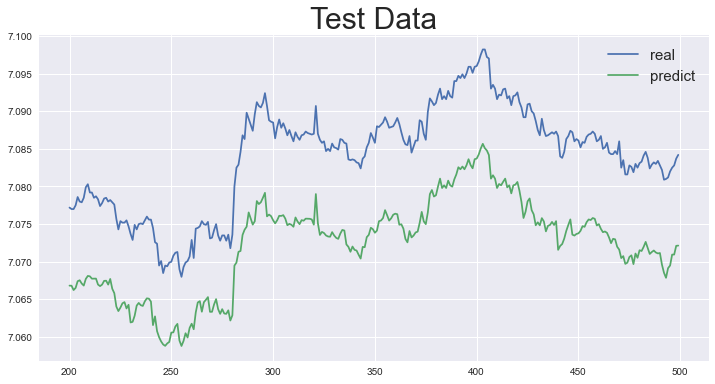

In [382]:
#在测试集上的预测
y_test_predict=model.predict(x_test)*scale
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题